In [261]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision.models.detection import transform
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.nn.functional import max_pool2d
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [262]:
batch_size = 16
epochs_number = 100

In [263]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [264]:
class CardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(CardClassifer,self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
         
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = self.fc3(x)
        
        return output

In [265]:
model = CardClassifer(num_classes=53)
print(model)

CardClassifer(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=53, bias=True)
)


In [266]:
#Loss Function
criterion = nn.CrossEntropyLoss()
#Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [267]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(15),     # Randomly rotate images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color adjustments
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_folder = r'C:\Users\piotr\Desktop\data\train'
valid_folder = r'C:\Users\piotr\Desktop\data\valid'
test_folder = r'C:\Users\piotr\Desktop\data\test'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [268]:
# Early stopping
import copy

class EarlyStopping():
  def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.counter = 0
    self.status = ""

  def __call__(self, model, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
      self.best_model = copy.deepcopy(model)
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
      self.best_model.load_state_dict(model.state_dict())
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.status = f"Stopped on {self.counter}"
        if self.restore_best_weights:
          model.load_state_dict(self.best_model.state_dict())
        return True
    self.status = f"{self.counter}/{self.patience}"
    return False

In [269]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [270]:
num_epochs = epochs_number
train_losses, val_losses = [], []

model = CardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
es = EarlyStopping(patience=3)

epoch = 0
done = False
while epoch < num_epochs and not done:
    epoch += 1
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")
    
     # Check early stopping criteria
    done = es(model, val_loss)
    print(f"Early Stopping: {es.status}")

Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 3.816661587041673, Validation loss: 3.2038897244435436
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/100 - Train loss: 2.8342183191653687, Validation loss: 2.1018558943046712
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/100 - Train loss: 2.3286325741414635, Validation loss: 1.90836732972343
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/100 - Train loss: 2.1305574166186836, Validation loss: 1.801285868320825
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/100 - Train loss: 1.9687287627337238, Validation loss: 1.517442190422202
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/100 - Train loss: 1.798822851271094, Validation loss: 1.4756233773141536
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/100 - Train loss: 1.6274279957678235, Validation loss: 1.3976974433323122
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/100 - Train loss: 1.4787801321506, Validation loss: 1.1010230415272262
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/100 - Train loss: 1.3487058019838203, Validation loss: 0.9981161459436957
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/100 - Train loss: 1.2595932360460975, Validation loss: 0.9597223585506656
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/100 - Train loss: 1.1835381383660708, Validation loss: 0.8153843582801099
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/100 - Train loss: 1.1047832337281387, Validation loss: 0.8367614692112185
Early Stopping: 1/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/100 - Train loss: 1.0289924403052515, Validation loss: 0.7351426900557751
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/100 - Train loss: 0.9837445347000144, Validation loss: 0.7750549988926582
Early Stopping: 1/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/100 - Train loss: 0.9313095768626314, Validation loss: 0.7231873125400183
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16/100 - Train loss: 0.8978883860806728, Validation loss: 0.6721207447771756
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/100 - Train loss: 0.8530540702725757, Validation loss: 0.7119659583523589
Early Stopping: 1/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/100 - Train loss: 0.8231516343474012, Validation loss: 0.6717620354778362
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19/100 - Train loss: 0.7911190562270746, Validation loss: 0.6576182500371394
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/100 - Train loss: 0.7482103038215687, Validation loss: 0.6518794320664316
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21/100 - Train loss: 0.7121890082580095, Validation loss: 0.6412868857383728
Early Stopping: 0/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22/100 - Train loss: 0.6750753465590359, Validation loss: 0.6422141799386942
Early Stopping: 1/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23/100 - Train loss: 0.6607618508713881, Validation loss: 0.7302839535587239
Early Stopping: 2/3


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24/100 - Train loss: 0.6313311959629544, Validation loss: 0.7029351076989804
Early Stopping: Stopped on 3


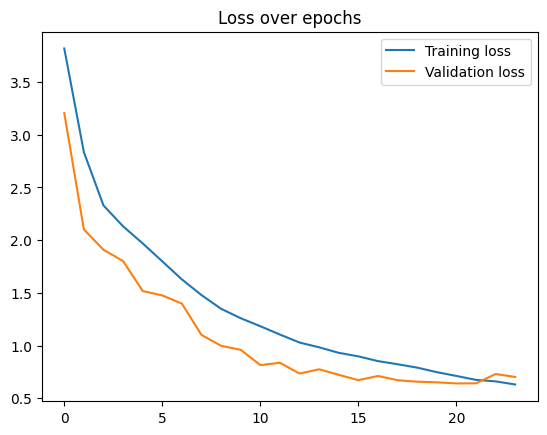

In [271]:
#Visualize Losses

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [272]:
# Calculate the Accuracy of the Model using test data
from sklearn.metrics import accuracy_score

model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)  # Get the class index with the highest probability
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 84.53%
